In [18]:
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from matplotlib import pyplot as plt

from interfaces import AbstractSolver
from methods import *
from problems import fermat_toricelly_steiner
from problems.problem_parmeters_generator import generate_points_to_cover
from utils import *

dim = 2
Q_radius = 6
x_solution = np.random.randn(dim)
radius = np.random.randint(1, Q_radius//2)
print("radius: ", radius)
# solution + radius should fit into Q set.
if np.linalg.norm(x_solution) + radius > Q_radius:
    x_solution = (x_solution / np.linalg.norm(x_solution)) * (Q_radius - radius - 1)
print("x_solution: ", x_solution[0:6], " radius: ", radius, " solution norm: ", np.linalg.norm(x_solution),
      " sum: ", np.linalg.norm(x_solution) + radius)
points_to_cover = generate_points_to_cover(x_solution, radius, 2)

radius:  1
x_solution:  [1.26633827 0.79801928]  radius:  1  solution norm:  1.4968124122568707  sum:  2.4968124122568707
norm:  0.9999999999999999


In [19]:
c = np.array([-1.11180359, -1.25603567])
x_f = np.array([ -14.55887278, -139.60406179])
x_d = c - x_f
print(x_d)
print(x_d * 2)

[ 13.44706919 138.34802612]
[ 26.89413838 276.69605224]


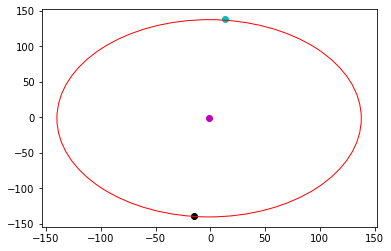

In [20]:
circle1 = plt.Circle(c, np.linalg.norm(c-x_f), color='r', fill=False)

fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
# (or if you have an existing figure)
# fig = plt.gcf()
# ax = fig.gca()

ax.add_patch(circle1)
ax.scatter(x_f[0], x_f[1], color="k")
ax.scatter(x_d[0], x_d[1], color="c")
ax.scatter(c[0], c[1], color="m")


plt.show()

[0.45420659 0.21454509]
2:  [0.2271033  0.10727255]
np.sqrt(2):  [0.32117256 0.15170629]


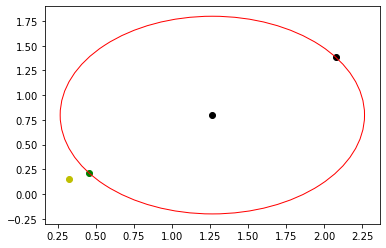

In [21]:
circle1 = plt.Circle(x_solution, radius, color='r', fill=False)
circle2 = plt.Circle((0, 0), Q_radius, color='b', fill=False)

fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
# (or if you have an existing figure)
# fig = plt.gcf()
# ax = fig.gca()

ax.add_patch(circle1)
# ax.add_patch(circle2)
#for point in points_to_cover:
ax.scatter(points_to_cover[0][0], points_to_cover[0][1], color="k")
ax.scatter(x_solution[0], x_solution[1], color="k")
ax.scatter(points_to_cover[1][0], points_to_cover[1][1], color="g")
ax.scatter(points_to_cover[1][0]/np.sqrt(2), points_to_cover[1][1]/np.sqrt(2), color="y")
print(points_to_cover[1])
print("2: ", points_to_cover[1]/2)
print("np.sqrt(2): ", points_to_cover[1]/np.sqrt(2))
plt.show()

In [159]:
from problems import *
from datetime import datetime

M = 4 * (Q_radius ** 2)  # np.linalg.norm(fun.call_grad(x_0))
n_exp = 1
n_iter = 100
mu = 1
original_dim = 2
constraints_dim = 2
dim = original_dim + constraints_dim

Q_radius = 6
x_solution = np.random.randn(original_dim)
radius = np.random.randint(1, Q_radius // 2)
# solution + radius should fit into Q set.
if np.linalg.norm(x_solution) + radius > Q_radius:
    x_solution = (x_solution / np.linalg.norm(x_solution)) * (Q_radius - radius - 1)
print("x_solution: ", x_solution[0:6], " radius: ", radius, " solution norm: ", np.linalg.norm(x_solution),
      " sum: ", np.linalg.norm(x_solution) + radius)
points_to_cover = generate_points_to_cover(x_solution, radius, 5)
print("points to cover shape: ", points_to_cover.shape)
phi_params_alpha = np.zeros((constraints_dim, original_dim))
for c in range(constraints_dim):
    col = np.abs(np.random.randn(original_dim))
    col = col / np.sum(col)
    print("col sum: ", np.sum(col))
    phi_params_alpha[c] = col
print("alpha shape: ", phi_params_alpha.shape)

x_args_array = np.zeros((n_exp, n_iter, dim))
f_vals_array = np.zeros((n_exp, n_iter))
f_raw_vals_array = np.zeros((n_exp, n_iter))
g_norm_array = np.zeros((n_exp, n_iter))
x_solutions = np.zeros((n_exp, dim))
f_solutions = np.zeros(n_exp)

def proj_Q(x):
    if np.linalg.norm(x) > Q_radius:
        # print("outside of Q, projecting original: ", ret, "norm: ", np.linalg.norm(ret))
        x = (x / np.linalg.norm(x)) * Q_radius
    for constr_ind in range(1, constraints_dim+1):
        if x[-constr_ind] < 0:
            x[-constr_ind] = 0
    return x

# это все вспомогательное нужно вынести куда-то
# проблема в том, что эти функции одновременно связаны и с минимизируемой функцией, и с методом
def first_order_subproblem_analytical(h_k, x_k, gr_k):
    ret = x_k - h_k * gr_k
    # new value should fit into Q set, so we check and project
    # print("first order ret: ", ret, " radius: ", Q_radius, " ret norm: ", np.linalg.norm(ret))
    return proj_Q(ret)

def estimation_adaptive_scipy(x_averaged):
    def estimation_x(x):
        lmbd = x_averaged[-constraints_dim:]
        f = np.max([np.square(np.linalg.norm(x - point)) for point in points_to_cover])
        phi = (np.square(x) @ phi_params_alpha.T) - 5
        return f + lmbd @ phi - (1 / 2) * (lmbd @ lmbd)

    def estimation_lmbd(l):
        x = x_averaged[:original_dim]
        f = np.max([np.square(np.linalg.norm(x - point)) for point in points_to_cover])
        phi = (np.square(x) @ phi_params_alpha.T) - 5
        # print("shapes l: ", l.shape, " phi: ", phi.shape)
        return f + l @ phi - (1 / 2) * (l @ l)

    y_lmbd_max = estimation_lmbd(
        np.array(phi_params_alpha @ np.square(x_averaged[:original_dim]) - 5))
    # print("lmbd max: ",
    # np.array([alpha @ np.square(x_averaged[:original_dim]) - 5 for alpha in phi_params_alpha]))
    # print("lmbd max calc: ",
    #       np.array(phi_params_alpha @ np.square(x_averaged[:original_dim]) - 5))
    x_orig = x_averaged[:original_dim]
    lmbd_avg = x_averaged[-constraints_dim:]
    fun_values = [np.square(np.linalg.norm(x_orig - point)) for point in points_to_cover]
    max_ind = np.concatenate(np.argwhere(fun_values == np.max(fun_values))).tolist()
    x_min = np.linalg.inv(np.diag(lmbd_avg.T @ phi_params_alpha + 1)) @ points_to_cover[max_ind[0]]
    # x_min_scp = minimize(estimation_x, x0=np.array([0.5] * original_dim), method='SLSQP')['x']
    # print("x_min    : ", x_min[:20])
    # print("x_min_scp: ", x_min_scp[:20])
    y_x_min = estimation_x(x_min)
    y_val = y_lmbd_max - y_x_min
    print("max - min  : ", y_val)
    return y_val

lmbd_solution = np.zeros((constraints_dim))
x_solution = np.concatenate([x_solution, lmbd_solution], axis=0)

print("============exp#{}============".format(0))

fun = fermat_toricelly_steiner(points_to_cover, phi_params_alpha)
method = SubgradientVIDescent(
    problem=fun,
    x_solution=x_solution,
    subproblem_fun=first_order_subproblem_analytical,
    estimation_fun=estimation_adaptive_scipy,
    strongly_convex_fun_const=mu,
    vi_rel_limitation=M)

raw_rand = np.random.randn(dim)
x_0 = 0.2 * raw_rand / np.linalg.norm(raw_rand)
print("x0: ", x_0)
print("x0 shape: ", x_0.shape)
xs, opt_params = method.minimize(x_0, n_iter=n_iter)
# local variables should be faster
f = method.f
g = method.grad

print("x solution: ", method.x_solution)
print("F solution: ", f(method.x_solution))

print("xs shape: ", np.array(xs).shape)
print("data saving")
start_time = datetime.now()
x_averaged = averaging(xs)
print("avg : ", (datetime.now() - start_time).total_seconds())
start_time = datetime.now()
f_vals = apply(x_averaged, f)
print("f_vals : ", (datetime.now() - start_time).total_seconds())
start_time = datetime.now()
g_norm = apply(xs[::100], lambda x: np.linalg.norm(g(x)))
print("g_norm : ", (datetime.now() - start_time).total_seconds())

start_time = datetime.now()
method.estimate(opt_params, x_averaged)
print("estimation : ", (datetime.now() - start_time).total_seconds())

x_solution:  [-1.08605918 -1.06822126]  radius:  2  solution norm:  1.5233585260017235  sum:  3.5233585260017235
norm:  1.9999999999999998
points to cover shape:  (5, 2)
col sum:  1.0
col sum:  0.9999999999999999
alpha shape:  (2, 2)
============exp#0============
constrints num:  2  original dim:  2
x0:  [ 0.06084339  0.14572325 -0.04748969  0.11317043]
x0 shape:  (4,)
total time:  0.017997
x solution:  [-1.08605918 -1.06822126  0.          0.        ]
F solution:  4.0
xs shape:  (100, 4)
data saving
avg :  0.0
f_vals :  0.009037
g_norm :  0.0
theoretical:  288.0
theoretical:  5.647058823529412
max - min  :  10.577574657148404
max - min  :  9.841380824430084
estimation :  0.001


In [148]:
def annotate(p, label = None):
    if not label:
        label = f"({p[0]:.2f}, {p[1]:.2f})"
    
    plt.annotate(label,
                 (p[0], p[1]),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center',
                 color = 'blue')
    pass

def annotate_plus(p, norm, label = None):
    if np.square(p) @ norm > 5:
        label = f"plus"
    else:
        label = f"minus"
    
    plt.annotate(label,
                 (p[0], p[1]),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center',
                 color = 'blue')
    pass

solution:  [-1.08605918 -1.06822126  0.          0.        ]
[-1.29701745 -0.37866571]


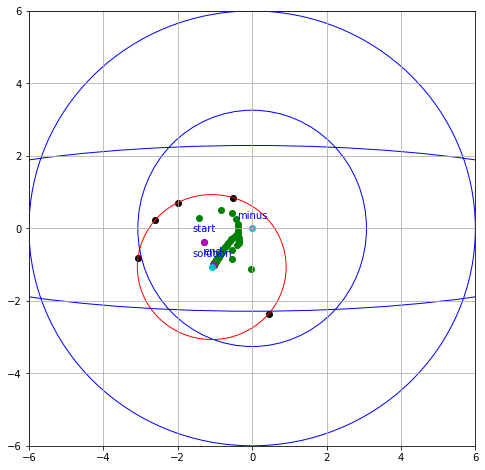

In [165]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse

circle1 = plt.Circle(x_solution[:original_dim], radius, color='r', fill=False)
print("solution: ", x_solution)
circle2 = plt.Circle((0, 0), Q_radius, color='b', fill=False)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot() # note we must use plt.subplots, not plt.subplot
# (or if you have an existing figure)
# fig = plt.gcf()
# ax = fig.gca()

ax.add_patch(circle1)
ax.add_patch(circle2)
for point in points_to_cover:
    ax.scatter(point[0], point[1], color="k")
for ind_x_k in range(x_averaged.shape[0]):
    x_k = x_averaged[ind_x_k]
    ax.scatter(x_k[0], x_k[1], color="g")
#     if (ind_x_k % 10 == 0):
#         annotate(x_k[:2], str(ind_x_k))
ax.scatter(x_averaged[-1][0], x_averaged[-1][1], color="m")
annotate(x_averaged[-1][:2], "end")
ax.scatter(x_averaged[0][0], x_averaged[0][1], color="m")
annotate(x_averaged[0][:2], "start")
print(x_averaged[0][:2])
# phi_0 * x^2  + phi_1 * y^2 = 5
const = 5
for phi in phi_params_alpha:
    ellipse = Ellipse(xy=(0, 0), width=2*np.sqrt(const/phi[0]), height=2*np.sqrt(const/phi[1]), 
                            edgecolor='b', fill=False)
    ax.add_patch(ellipse)

# ax.plot([0, phi_params_alpha[0][0]], [0, phi_params_alpha[0][1]], c = 'blue')
# annotate(phi_params_alpha[0])

# ax.scatter(x_0[0], x_0[1], color="y")
ax.scatter(x_solution[0], x_solution[1], color="c")
annotate(x_solution[:2], "solution")
# ax.scatter(0, 0, color="c")
ax.scatter(0, 0, color="c")
annotate_plus([0,0],  phi_params_alpha[0])
# xSeries = np.array([-0.01, 0.05])
# print("phi: ", phi_params_alpha[0])
# ySeries12 = - (xSeries * phi_params_alpha[0][0]) / phi_params_alpha[0][1]
# print("yS: ", ySeries12)
# ax.plot(xSeries, ySeries12, c = 'blue')
# print("diff solution - start     : ", x_solution - x_0)
# print("diff solution - start norm: ", np.linalg.norm(x_solution - x_0))
#print("diff solution - end       : ", x_k - x_0)
#print("diff solution - end norm  : ", np.linalg.norm(x_k - x_0))

#ax.scatter(x_args_array[0][-1][0], x_args_array[0][-1][1], color="m")
ax.grid(True)
ax.set_xlim([-6, 6])
ax.set_ylim([-6, 6])
plt.show()

norm:  43.0
solution:  [-1.21710862 -0.67371737]


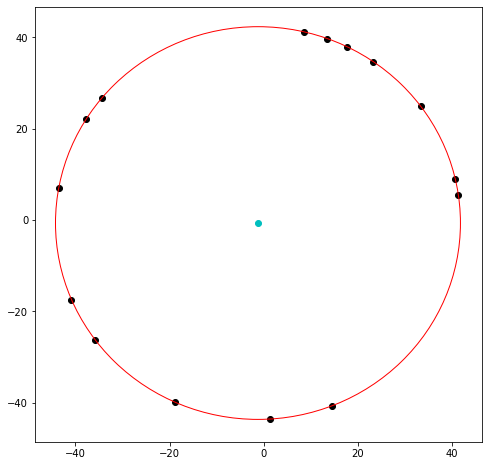

In [4]:
import numpy as np
from problem_parmeters_generator import generate_points_to_cover
from matplotlib import pyplot as plt

Q_radius = 1_000
dim = 2
x_solution = np.random.randn(dim)
radius = np.random.randint(1, Q_radius//2)

points_to_cover = generate_points_to_cover(x_solution, radius, 15)

circle1 = plt.Circle(x_solution, radius, color='r', fill=False)
print("solution: ", x_solution)
circle2 = plt.Circle((0, 0), Q_radius, color='b', fill=False)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot() # note we must use plt.subplots, not plt.subplot
# (or if you have an existing figure)
# fig = plt.gcf()
# ax = fig.gca()

ax.add_patch(circle1)
#ax.add_patch(circle2)
for point in points_to_cover:
    ax.scatter(point[0], point[1], color="k")
# for x_k in x_args_array[0]:
#     ax.scatter(x_k[0], x_k[1], color="g")
# ax.scatter(x_0[0], x_0[1], color="y")
ax.scatter(x_solution[0], x_solution[1], color="c")
# print("diff solution - start     : ", x_solution - x_0)
# print("diff solution - start norm: ", np.linalg.norm(x_solution - x_0))
#print("diff solution - end       : ", x_k - x_0)
#print("diff solution - end norm  : ", np.linalg.norm(x_k - x_0))

#ax.scatter(x_args_array[0][-1][0], x_args_array[0][-1][1], color="m")
plt.show()

In [36]:
prefix = "./experiments/SubgradientMirrorDescent/covering_sphere_problem_strong_convex/"
rad_5 = np.load(prefix + "exp#0_iter#1729_qRadius#6_dim#1500_r#5.npz")
rad_10 = np.load(prefix + "exp#0_iter#1729_qRadius#6_dim#1500_r#10.npz")
rad_20 = np.load(prefix + "exp#0_iter#1729_qRadius#6_dim#1500_r#20.npz")
rad_100 = np.load(prefix + "exp#0_iter#1729_qRadius#6_dim#1500_r#100.npz")

n_it = 1729
f_vals_5 = rad_5["f_vals"][0]
f_solution_5 = rad_5["f_solution"]
g_norm_array_5 = rad_5["g_norm"]
f_vals_10 = rad_10["f_vals"][0]
f_solution_10 = rad_10["f_solution"]
g_norm_array_10 = rad_10["g_norm"]
f_vals_20 = rad_20["f_vals"][0]
f_solution_20 = rad_20["f_solution"]
g_norm_array_20 = rad_20["g_norm"]
f_vals_100 = rad_100["f_vals"][0]
f_solution_100 = rad_100["f_solution"]
g_norm_array_100 = rad_100["g_norm"]

In [37]:
def adaptive(i, g_norm):
    # this part cut due to small irrelevant values on a small amount of iterations
    if i < 10:
        return 10
    return (2 / (2 * i * (i + 1))) * np.sum(
        [k * np.square(g_norm[0][k]) / (k + 1) for k in range(i)], axis=0)

def non_adaptive(i):
    return 2 * ((2*6) ** 2) / (2 * (i + 1))

f_vals shape:  (1729,)
1 shapes:  (1729,)
[416.49591497 416.49591497  48.04209682  13.39226345   5.56756326
   2.98273214   1.91869509   1.38441589   1.06960482   0.86240496]
1 disc:  (1729,)


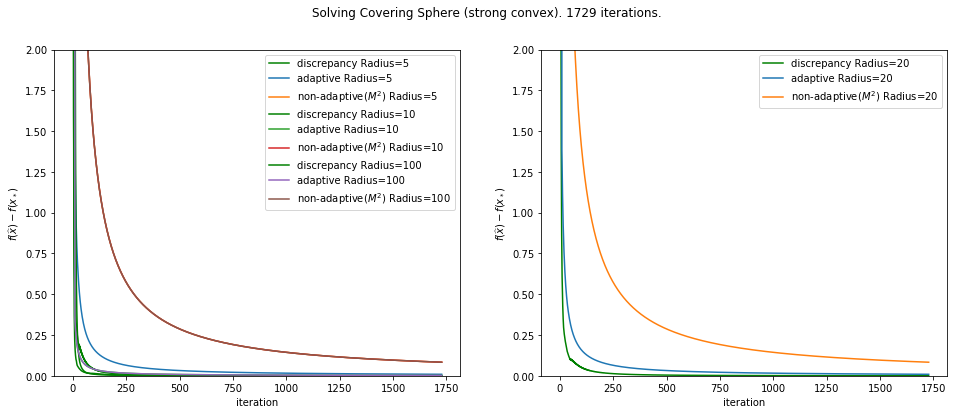

In [46]:

fig = plt.figure(figsize=(16, 6))
print("f_vals shape: ", f_vals.shape)
fig.suptitle(f'Solving Covering Sphere (strong convex). 1729 iterations.')

ax = fig.add_subplot(1, 2, 1)
ax.set_ylabel(f'$f(\widehat{{x}}) - f(x_*)$')

print("1 shapes: ", f_vals.shape)
print([f_vals - f_solution][0][0:10])
f_discrepancy = np.array([f_vals - f_solution][0])
print("1 disc: ", f_discrepancy.shape)

ax.set_xlabel('iteration')
ax.set_ylim([0, 2])
ax.plot(np.arange(n_it), np.array([f_vals_5 - f_solution_5][0]), label="discrepancy Radius=5", color="g")

ax.plot(list(range(n_it)), [adaptive(iter, g_norm_array_5) for iter in range(n_it)],
        label="adaptive Radius=5")

ax.plot(list(range(n_it)), [non_adaptive(iter) for iter in range(n_it)],
        label=f'non-adaptive($M^2$) Radius=5')

ax.plot(np.arange(n_it), np.array([f_vals_10 - f_solution_10][0]), label="discrepancy Radius=10", color="g")

ax.plot(list(range(n_it)), [adaptive(iter, g_norm_array_10) for iter in range(n_it)],
        label="adaptive Radius=10")

ax.plot(list(range(n_it)), [non_adaptive(iter) for iter in range(n_it)],
        label=f'non-adaptive($M^2$) Radius=10')

ax.plot(np.arange(n_it), np.array([f_vals_100 - f_solution_100][0]), label="discrepancy Radius=100", color="g")

ax.plot(list(range(n_it)), [adaptive(iter, g_norm_array_100) for iter in range(n_it)],
        label="adaptive Radius=100")

ax.plot(list(range(n_it)), [non_adaptive(iter) for iter in range(n_it)],
        label=f'non-adaptive($M^2$) Radius=100')

ax.legend(loc="upper right")

ax = fig.add_subplot(1, 2, 2)
ax.set_ylabel(f'$f(\widehat{{x}}) - f(x_*)$')

ax.set_xlabel('iteration')
ax.set_ylim([0, 2])
ax.plot(np.arange(n_it), np.array([f_vals_20 - f_solution_20][0]), label="discrepancy Radius=20", color="g")

ax.plot(list(range(n_it)), [adaptive(iter, g_norm_array_20) for iter in range(n_it)],
        label="adaptive Radius=20")

ax.plot(list(range(n_it)), [non_adaptive(iter) for iter in range(n_it)],
        label=f'non-adaptive($M^2$) Radius=20')
ax.legend(loc="upper right")

plt.show()

In [ ]:
fig = plt.figure(figsize=(, 6))
print("f_vals shape: ", f_vals.shape)
fig.suptitle(f'Solving Covering Sphere (strong convex). 1729 iterations.')


ax = fig.add_subplot(1, 1, 1)
ax.set_ylabel(f'$f(\widehat{{x}}) - f(x_*) Radius = 20$')

ax.set_xlabel('iterations')
ax.set_ylim([0, 2])
ax.plot(np.arange(n_it), np.array([f_vals_20 - f_solution_20][0]), label="discrepancy Radius=20", color="g")

ax.plot(list(range(n_it)), [adaptive(iter, g_norm_array_20) for iter in range(n_it)],
        label="adaptive Radius=20")

ax.plot(list(range(n_it)), [non_adaptive(iter) for iter in range(n_it)],
        label=f'non-adaptive($M^2$) Radius=20')
ax.legend(loc="upper right")

plt.show()